# Practical 2

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.
Let's start with a bit of exploration.

### Tasks 1.1: Dataset Exploration 
- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

file = 'data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample (row)
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1) #check which rows are without missings
X_all = X_all[idx]
t_all = t_all[idx]

In [2]:
df.describe(include = [np.number])

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,...,1080.000000,867.000000,795.000000,1080.000000,1005.000000,1080.000000,900.000000,870.000000,810.000000,1080.000000
mean,0.425810,0.617102,0.319088,2.297269,3.843934,0.233168,0.181846,3.537109,0.212574,1.428682,...,0.226676,0.157914,0.134762,0.121521,0.131053,0.446073,0.169609,0.183135,0.205440,1.337784
std,0.249362,0.251640,0.049383,0.347293,0.933100,0.041634,0.027042,1.295169,0.032587,0.466904,...,0.028989,0.029537,0.027417,0.014276,0.023863,0.066432,0.059402,0.040406,0.055514,0.317126
min,0.145327,0.245359,0.115181,1.330831,1.737540,0.063236,0.064043,1.343998,0.112812,0.429032,...,0.155869,0.088305,0.080657,0.067254,0.085419,0.258626,0.079691,0.105537,0.101787,0.586479
25%,0.288121,0.473361,0.287444,2.057411,3.155678,0.205755,0.164595,2.479834,0.190823,1.203665,...,0.206395,0.136424,0.115554,0.110839,0.113506,0.398082,0.125848,0.155121,0.165143,1.081423
50%,0.366378,0.565782,0.316564,2.296546,3.760855,0.231177,0.182302,3.326520,0.210594,1.355846,...,0.224000,0.152313,0.129468,0.121626,0.126523,0.448459,0.158240,0.174935,0.193994,1.317441
75%,0.487711,0.698032,0.348197,2.528481,4.440011,0.257261,0.197418,4.481940,0.234595,1.561316,...,0.241655,0.174017,0.148235,0.131955,0.143652,0.490773,0.197876,0.204542,0.235215,1.585824
max,2.516367,2.602662,0.497160,3.757641,8.482553,0.539050,0.317066,7.464070,0.306247,6.113347,...,0.358289,0.282016,0.261506,0.158748,0.256529,0.759588,0.479763,0.360692,0.413903,2.129791


In [3]:
df.describe(include = [object])

,MouseID,Genotype,Treatment,Behavior,class
count,1080,1080,1080,1080,1080
unique,1080,2,2,2,8
top,3498_5,Control,Memantine,S/C,c-CS-m
freq,1,570,570,555,150


The dataset contains 77 numerical columns, which may be used as features, as well as 1080 observations (or 'samples'). It is to be noted, that it is a longitudinal dataset and therefore contains repeated measures on the individual subjects. Correlation between the observations is present. 8 different labels are contained, as indicated by the facotr-variable 'class'.

In the following a random subset of the data is used with 105 samples and 64 features, where no missing values are present. The 8 labels are coarse-grained into two classes decribing the behaviour of the subject. This is the target variable.

**Nr. of samples/features & labels**

In [4]:
print('Nr of samples: ' + str(X_all.shape[0]))
print('Nr of features: ' + str(X_all.shape[1]))
print('')

nr_labels = len(df['class'].unique())
print('Nr. of labels: ' + str(nr_labels))
print('')
print('Label names: ')
print(df['class'].unique())

Nr of samples: 105
Nr of features: 64

Nr. of labels: 8

Label names: 
['c-CS-m' 'c-SC-m' 'c-CS-s' 'c-SC-s' 't-CS-m' 't-SC-m' 't-CS-s' 't-SC-s']


**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [5]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # shuffle vectors
    idx = list(range(len(y)))
    idx_shuffled = np.random.permutation(idx)
    y_shuffled = y[idx_shuffled]
    X_shuffled = X[idx_shuffled]
    
    # slice vectors
    idx_cutoff = round((1-frac)*len(y)) #seperates training from test (in this order)
    X_train = X_shuffled[:idx_cutoff, :]
    X_test = X_shuffled[idx_cutoff:, :]
    y_train = y_shuffled[:idx_cutoff]
    y_test = y_shuffled[idx_cutoff:]
    return X_train, X_test, y_train, y_test

def preprocess(X):
    X_norm = (X - X.mean(axis = 0)) / X.std(axis = 0)
    return X_norm

def calculate_accuracy(t_pred, t_true):
    accuracy_list = [1 if pred == null else 0 for pred, null in zip(t_pred, t_true)]
    accuracy = sum(accuracy_list)/len(accuracy_list)
    return accuracy

In [6]:
X_train, X_test, t_train, t_test = split_data(X_all, t_all)
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [7]:
pd.DataFrame(X_train).describe().round(3)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,...,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000,74.000
mean,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,...,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000
std,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,...,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007,1.007
min,-0.954,-1.504,-1.741,-2.600,-2.335,-2.107,-2.432,-1.662,-1.728,-1.458,...,-2.199,-2.378,-1.237,-2.175,-2.869,-1.690,-2.734,-2.302,-2.189,-2.704
25%,-0.569,-0.608,-0.666,-0.656,-0.608,-0.732,-0.768,-0.877,-0.633,-0.526,...,-0.525,-0.591,-0.610,-0.636,-0.692,-0.795,-0.502,-0.621,-0.724,-0.603
50%,-0.298,-0.243,-0.127,0.050,-0.064,0.032,0.054,-0.070,-0.044,-0.087,...,-0.063,0.040,-0.293,-0.056,-0.075,-0.012,-0.038,-0.053,-0.051,0.044
75%,0.200,0.358,0.687,0.614,0.577,0.560,0.587,0.708,0.494,0.352,...,0.555,0.713,0.305,0.617,0.830,0.766,0.561,0.585,0.652,0.725
max,6.182,4.608,2.659,2.355,2.440,2.918,2.609,3.009,2.558,6.132,...,2.653,2.772,4.807,2.806,2.022,2.911,2.337,2.157,3.049,2.024


In [8]:
X_train.shape

(74, 64)

In [9]:
t_train.shape

(74,)

In [10]:
X_test.shape

(31, 64)

In [11]:
t_test.shape

(31,)

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

**Task 2.1**

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

In [12]:
def compute_lda_weights(x, y):
    
    # seperate predictors into class 1 and class 0 obs. by boolean indexing
    c1_obs = x[y]
    c0_obs = x[~y]
    # compute columnwise (array-axis 0) class means
    c1_mean_vec = np.mean(c1_obs, axis = 0)
    c0_mean_vec = np.mean(c0_obs, axis = 0)
    m_diff = c1_mean_vec - c0_mean_vec
    
    # within-class covariance matrices   
    c1_obs_centered = np.transpose(c1_obs - c1_mean_vec) #transformation needed to match dimensions
    c1_cov_mat = np.matmul(c1_obs_centered, np.transpose(c1_obs_centered))
    c0_obs_centered = np.transpose(c0_obs - c0_mean_vec)
    c0_cov_mat = np.matmul(c0_obs_centered, np.transpose(c0_obs_centered))
    
    Sw = c1_cov_mat + c0_cov_mat
    Sw_inv = np.linalg.inv(Sw)
    weights = np.matmul(Sw_inv, c1_mean_vec - c0_mean_vec)
    
    return c1_mean_vec, c0_mean_vec, m_diff, weights

Text(0.5, 0, 'predictors')

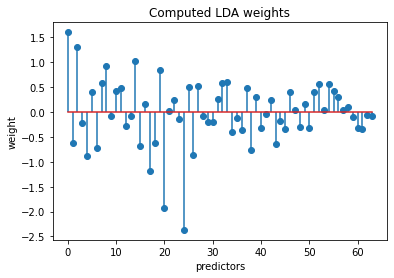

In [13]:
m1, m0, mdiff, w_lda = compute_lda_weights(X_train, t_train)

plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

### Task 2.3

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

In [14]:
X_cl0 = X_train[~t_train]
X_cl1 = X_train[t_train]
X_cl0_proj = X_cl0 @ w_lda # substract mean from predictor?
X_cl1_proj = X_cl1 @ w_lda # substract mean from predictor?

X_cl0_test = X_test[~t_test]
X_cl1_test = X_test[t_test]
X_cl0_test_proj = X_cl0_test @ w_lda # substract mean from predictor?
X_cl1_test_proj = X_cl1_test @ w_lda # substract mean from predictor?

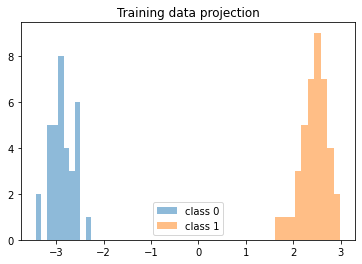

In [15]:
plt.title('Training data projection')
_ = plt.hist(X_cl0_proj,label='class 0',alpha=0.5)
_ = plt.hist(X_cl1_proj,label='class 1',alpha=0.5)
_ = plt.legend()

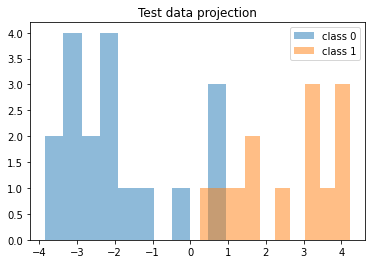

In [16]:
plt.title('Test data projection')
_ = plt.hist(X_cl0_test_proj,label='class 0',alpha=0.5)
_ = plt.hist(X_cl1_test_proj,label='class 1',alpha=0.5)
_ = plt.legend()

### Task 2.4 

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [17]:
c = np.matmul(w_lda, 1/2 * (m1 + m0))
c.round(4)

-0.2153

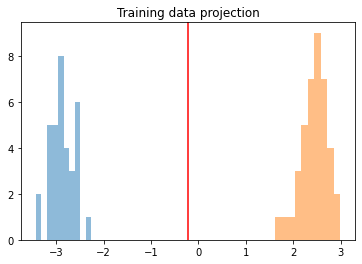

In [18]:
plt.title('Training data projection')
_ = plt.hist(X_cl0_proj,label='class 0',alpha=0.5)
_ = plt.hist(X_cl1_proj,label='class 1',alpha=0.5)
_ = plt.axvline(c, color = 'red')

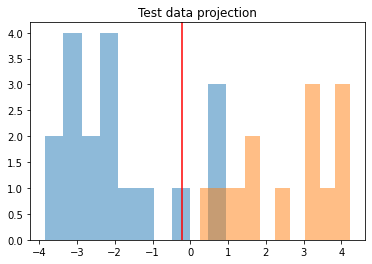

In [19]:
plt.title('Test data projection')
_ = plt.hist(X_cl0_test_proj,label='class 0',alpha=0.5)
_ = plt.hist(X_cl1_test_proj,label='class 1',alpha=0.5)
_ = plt.axvline(c, color = 'red')

In [20]:
t_pred = np.matmul(X_train, w_lda) >= c
t_pred_test = np.matmul(X_test, w_lda) >= c

In [21]:
print('Training Set Cross Table')
pd.crosstab(t_pred,t_train, rownames = ['t_pred'], colnames = ['t_true'])

Training Set Cross Table


t_true,False,True
t_pred,,
False,34,0
True,0,40


In [22]:
print('Test set cross table')
pd.crosstab(t_pred_test,t_test, rownames = ['t_pred'], colnames = ['t_true'])

Test set cross table


t_true,False,True
t_pred,,
False,14,0
True,4,13


In [23]:
calculate_accuracy(t_pred_test, t_test)

0.8709677419354839

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [24]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

X_all, t_all = pickle.load(open('data/cnn_features.pickle', 'rb'))
X_train, X_test, t_train, t_test = split_data(X_all, t_all)
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [25]:
X_train.shape

(1400, 256)

In [26]:
X_test.shape

(600, 256)

In [27]:
t_train.shape

(1400,)

In [28]:
t_test.shape

(600,)

**Task 3.0: Normalize the data**

Make sure the data has has zero mean and variance 1 per feature.

In [29]:
pd.DataFrame(X_train).describe().round(3)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
count,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,...,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000,1400.000
mean,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,...,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-3.068,-3.318,-3.113,-3.158,-4.019,-3.597,-3.039,-3.068,-3.043,-2.912,...,-3.745,-3.261,-2.944,-3.294,-3.909,-3.378,-2.929,-3.944,-3.191,-3.290
25%,-0.689,-0.653,-0.688,-0.688,-0.673,-0.659,-0.660,-0.675,-0.673,-0.673,...,-0.652,-0.698,-0.697,-0.654,-0.588,-0.645,-0.754,-0.647,-0.665,-0.686
50%,-0.051,-0.023,-0.014,0.057,0.016,-0.004,-0.016,0.025,-0.040,-0.030,...,0.019,-0.015,-0.049,0.005,0.048,0.049,-0.010,0.010,0.012,-0.010
75%,0.643,0.623,0.691,0.685,0.671,0.636,0.609,0.679,0.660,0.684,...,0.641,0.707,0.657,0.745,0.715,0.646,0.689,0.652,0.697,0.704
max,4.155,4.517,3.929,3.048,3.141,3.439,3.589,3.677,3.247,2.952,...,3.112,3.048,4.506,3.455,2.426,3.523,3.487,3.007,3.174,3.257


In [30]:
pd.Series(t_all).unique()

array([1, 0])

**Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
Where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  
Hints:  
(a) There is a bias term in logistic regression  
(b) Use a small value for weight init to avoid numerical problems.

2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

In [31]:
def sigma(x):
        return  (1 / (1 + np.exp(-x)))
    
def calc_eta(weights, x):
        return(weights.T @ x)
    

def IRLS(X, t, threshold = 0.01):
    
    def update_weights(weights, y, R, t=t, X=X):
        XRX_inv = np.linalg.inv(X.T @ R @ X)
        result = weights - (XRX_inv @ X.T @ (y-t))
        return result, weights
        
    def update_predictors(weights, X=X):
        y = np.array([sigma(calc_eta(weights, x)) for x in X])
        R = np.diag((y * (1-y)).ravel())
        return y, R
    
    # initialize weights
    nr_samples = X.shape[0]
    nr_features = X.shape[1]
    weights = np.zeros((nr_features)) + 0.1
    
    # calculate predictors and weights repeatedly
    for i in range(20):
        y, R = update_predictors(weights)
        weights, old_weights = update_weights(weights, y, R)
        acc = calculate_accuracy(y.round(), t)
        print("round " + str(i) + ' - training set accuracy: ' + str(acc))
        
        #check convergence
        changes = np.absolute(weights - old_weights)
        if all(np.less_equal(changes, threshold)):
            print('Convergence')
            break
    
    
    return weights

In [32]:
w_irls = IRLS(X_train, t_train, threshold = .01)

round 0 - training set accuracy: 0.6214285714285714
round 1 - training set accuracy: 0.89
round 2 - training set accuracy: 0.9678571428571429
round 3 - training set accuracy: 0.9821428571428571
round 4 - training set accuracy: 0.9871428571428571
round 5 - training set accuracy: 0.9971428571428571
round 6 - training set accuracy: 1.0
round 7 - training set accuracy: 1.0
round 8 - training set accuracy: 1.0
round 9 - training set accuracy: 1.0
round 10 - training set accuracy: 1.0
round 11 - training set accuracy: 1.0
round 12 - training set accuracy: 1.0
round 13 - training set accuracy: 1.0
round 14 - training set accuracy: 1.0
round 15 - training set accuracy: 1.0
round 16 - training set accuracy: 1.0
round 17 - training set accuracy: 1.0
round 18 - training set accuracy: 1.0
round 19 - training set accuracy: 1.0


In [33]:
y = np.array([sigma(calc_eta(w_irls, x)) for x in X_test])
print('Test Accuracy')
print(calculate_accuracy(y.round(), t_test))

Test Accuracy
0.8516666666666667


### Check with sklearn

In [34]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty = 'none')
logreg.fit(X_train, t_train.ravel())

print('Training accuracy')
t_pred = logreg.predict(X_train)
print(calculate_accuracy(t_pred, t_train))

print('Test accuracy')
t_pred = logreg.predict(X_test)
score_noreg = calculate_accuracy(t_pred, t_test)
print(score_noreg)

Training accuracy
1.0
Test accuracy
0.8633333333333333


**Task 3.2: Logistic Regression with Regularization**

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [35]:
from matplotlib import pyplot as plt
import random

In [36]:
C = np.linspace(.02, 1, 25)

logreg_l2 = [LogisticRegression(penalty = 'l2', C = c).fit(X_train, t_train.ravel()) for c in C]
t_pred_l2 = [i.predict(X_test) for i in logreg_l2]
scores_l2 = [calculate_accuracy(t_pred, t_test) for t_pred in t_pred_l2]

logreg_l1 = [LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear').fit(X_train, t_train.ravel()) for c in C]
t_pred_l1 = [i.predict(X_test) for i in logreg_l1]
scores_l1 = [calculate_accuracy(t_pred, t_test) for t_pred in t_pred_l1]

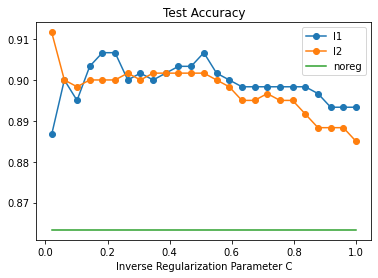

In [37]:
regplot = [None, None, None]
l1_plot, = plt.plot(np.linspace(0.02, 1, 25), scores_l1, '-o')
l1_plot.set_label('l1')
l2_plot, = plt.plot(np.linspace(0.02, 1, 25), scores_l2, '-o')
l2_plot.set_label('l2')
noreg_plot, = plt.plot(np.linspace(0.02, 1, 25), [score_noreg]*25, '-')
noreg_plot.set_label('noreg')
plt.xlabel('Inverse Regularization Parameter C')
plt.legend()
plt.title('Test Accuracy')
plt.show()

In [38]:
coefs_l1 = np.array([np.array(i.coef_).ravel() for i in logreg_l1])
coefs_l2 = np.array([np.array(i.coef_).ravel() for i in logreg_l2])

Text(0.5, 0, 'Inverse Regularization Parameter C')

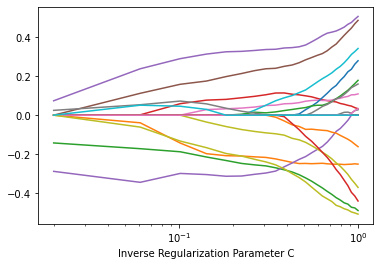

In [39]:
# Plot of coefficients vs. alphas
#plt.figure(figsize = (16,10))
for i in random.sample(range(coefs_l1.shape[1]), 20):
        plt.plot(C, coefs_l1.T[i])
plt.xscale('log')
plt.xlabel('Inverse Regularization Parameter C')

Text(0.5, 0, 'Inverse Regularization Parameter C')

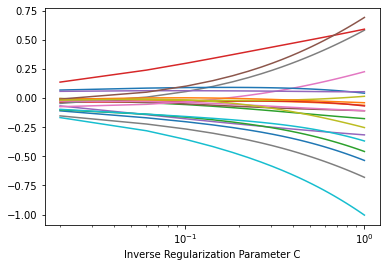

In [40]:
# Plot of coefficients vs. alphas
#plt.figure(figsize = (16,10))
for i in random.sample(range(coefs_l2.shape[1]), 20):
        plt.plot(C, coefs_l2.T[i])
plt.xscale('log')
plt.xlabel('Inverse Regularization Parameter C')